In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import pylab as pl
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.svm import SVC
%matplotlib inline

## Read in Data

In [95]:
data = pd.read_csv('FMADatasetTrans-cleaned.csv').drop('Unnamed: 0',axis=1)
response = pd.Series.from_csv('response.csv')

C:\Users\prern\Anaconda3\lib\site-packages\pandas\core\series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [96]:
response.value_counts()

Rock                   1997
Experimental           1344
Electronic             1258
Hip-Hop                 369
Folk                    339
Pop                     325
International           237
Classical               234
Instrumental            169
Spoken                  118
Old-Time / Historic      95
Jazz                     93
Soul-RnB                 39
Country                  32
Blues                    29
Easy Listening            4
dtype: int64

In [97]:
data['genre'] = response
data=data.loc[data['genre']!='Easy Listening'].reset_index(drop=True)
response = data['genre'].copy(deep=True)
data=data.drop('genre',axis=1)
response


0             Hip-Hop
1                 Pop
2                Rock
3                Rock
4                Rock
5                Rock
6                Rock
7                Rock
8                Rock
9                Rock
10               Rock
11               Rock
12               Rock
13               Rock
14               Rock
15               Rock
16               Rock
17               Rock
18               Rock
19               Rock
20               Rock
21               Rock
22               Rock
23               Rock
24               Rock
25               Rock
26               Rock
27               Rock
28         Electronic
29         Electronic
            ...      
6648     Experimental
6649     Experimental
6650     Experimental
6651     Experimental
6652     Experimental
6653     Experimental
6654     Experimental
6655     Experimental
6656     Experimental
6657       Electronic
6658       Electronic
6659    International
6660    International
6661    International
6662    In

In [98]:
le = LabelEncoder() #encode variables so that they can be put into a model
responseEncoded = le.fit_transform(response)
responseEncoded

array([ 6, 11, 12, ...,  5,  5,  5], dtype=int64)

## Visualizing Dataset in 2D

In [99]:
def plotClasses2D(X,y,dimensionality_reduction='PCA',title=None):
    '''
    Use this to visualize the separation of classes in two dimensions.'''
    if dimensionality_reduction=='PCA':
        pca = PCA(n_components=2) #two dimensions to plot on two dimensions
        xPlot = pca.fit_transform(X)
    elif dimensionality_reduction=='TSNE':
        tsne = TSNE(n_components=2)
        xPlot = tsne.fit_transform(X)
    else:
        xPlot=X
    df = pd.DataFrame(xPlot)
    if len(df.columns)!=2:
        return "DimError: Can't plot data not in two dimensions"
    df['y'] = y
    plt.figure()
    for label in df['y'].unique():
        sns.regplot(df[0].loc[df['y']==label],df[1].loc[df['y']==label],fit_reg=False,label=label)
        plt.legend(bbox_to_anchor=(1.1,1.05))
        if title!=None:
            plt.title(title)

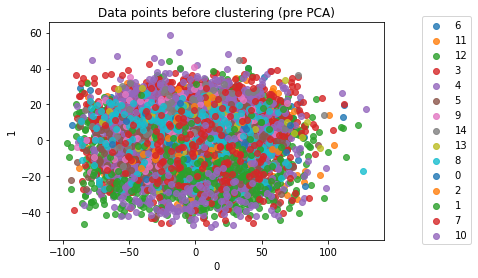

In [100]:
# How our data looks before clustering
plotClasses2D(data,responseEncoded,dimensionality_reduction='PCA',title='Data points before clustering (pre PCA)')

## Comparing perfomance of k-Means and GMM

In [101]:
kmeans = KMeans(init='k-means++',n_clusters=7,n_init=10)
kmeans.fit_predict(data)

array([0, 3, 4, ..., 2, 3, 3])

In [102]:
gmm = GaussianMixture(n_components=7,random_state=0).fit(data)
prediction = gmm.predict(data)
adjusted_rand_score(responseEncoded,prediction)

0.008349446117270315

In [103]:
adjusted_rand_score(kmeans.labels_,prediction)

0.9959327030734206

In [104]:
adjusted_rand_score(responseEncoded,kmeans.labels_)

0.008437714847292773

In [105]:
kmeans = KMeans(init='k-means++',n_clusters=16,n_init=10)
kmeans.fit_predict(data)

array([12, 15, 10, ..., 11,  9,  9])

In [106]:
adjusted_rand_score(responseEncoded,kmeans.labels_)

0.014726961922628307

In [107]:
gmm = GaussianMixture(n_components=16,random_state=0).fit(data)
prediction = gmm.predict(data)
adjusted_rand_score(responseEncoded,prediction)

0.016333595679729772

In [108]:
prediction

array([ 0,  2, 13, ..., 14, 10, 12], dtype=int64)

## Using labels from clustering for SVM classification

In [109]:
gmm = GaussianMixture(n_components=7,random_state=0).fit(data)
preds = gmm.predict(data)

In [110]:
svm = SVC(kernel='linear')

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X=data
y=kmeans.labels_

In [113]:
X_train, X_test, y_train, y_test = train_test_split(    X, y, test_size=0.33, random_state=42)

In [114]:
svm.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [115]:
y_pred=svm.predict(X_test)

In [116]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [117]:
accuracy_score(y_test, y_pred)

0.9287658802177858

In [118]:
f1_score(y_test, y_pred, average='macro')

0.9292173989954067

In [119]:
kmeans = KMeans(init='k-means++',n_clusters=7,n_init=10,random_state=0)
kmeans.fit_predict(data)

array([1, 0, 6, ..., 3, 0, 0])

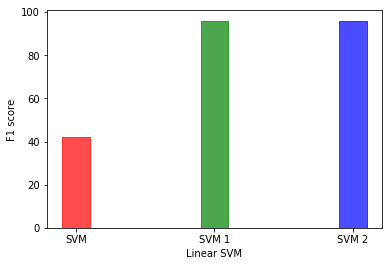

In [120]:
from pylab import rcParams
#plt.rcdefaults()
 
y_axis = ('SVM', 'SVM 1', 'SVM 2')
y_pos = np.arange(len(y_axis))
performance = [42,96,96]
 
barlist = plt.bar(y_pos, performance, align='center', alpha=0.7, width=[0.2,0.2,0.2], label=['SVM (old grouping)', 'SVM 1 (new grouping based on k-Means)', 'SVM 2 (new grouping based on GMM)'])
plt.xlabel('Linear SVM')
plt.xticks(y_pos, y_axis)
plt.ylabel('F1 score')
#plt.title('Comparison of classification performance using old grouping of songs and new grouping of songs')
rcParams['figure.figsize'] = 4,4
barlist[0].set_color('r')
barlist[1].set_color('g')
barlist[2].set_color('b')
#plt.legend()
plt.show()
